# Model free methods: Monte-Carlo

## Gynmasium environments
[Farama Gym](https://gymnasium.farama.org/index.html) is a collection of environments designed for developing and comparing reinforcement learning algorithms. It is a Python library that offers easy-to-use interfaces for a wide range of environments, originally provided by OpenAI. The environments are organized into categories such as classic control, Box2D, toy text, algorithmic, MuJoCo, robotics, and more.

Each environment is implemented as a Python class that provides consistent methods to interact with them. These methods include:

- `reset()`: Resets the environment to its initial state and returns the initial `observation`.
- `step(action)`: Executes the provided action, returning the next `observation`, the `reward`, two termination booleans (`truncated` or `terminated`), and an additional `info` dictionary.
- `render()`: Renders the environment for visualization purposes.
- `close()`: Closes the environment and frees resources.
- `seed(seed_value)`: Sets the seed for the environment to ensure reproducible results.

This standardized interface makes it simple to develop, test, and compare RL algorithms across different environments.


### FrozenLake-v1
The FrozenLake-v1 environment is a 4x4 grid world where the agent has to reach the goal without falling into a hole. The agent can move in four directions: up, down, left, and right. The environment is stochastic, meaning that the agent can slip and move in a different direction than the one it chose. The environment is considered solved when the agent reaches the goal state. The agent receives a reward of 1 when it reaches the goal and 0 otherwise.

<img src="https://gymnasium.farama.org/_images/frozen_lake.gif"/>

3 different versions of the FrozenLake environment are proposed:

* A deterministic one
* A stochastic one with only 2 holes
* A stochastic one with 4 holes

Your implementation should be able to solve always the deterministic, around 50% of the time the 2 holes version and less than 10% of the time the 4 holes version.

In [1]:
import gymnasium as gym

# env = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"],  map_name="4x4", is_slippery=False, render_mode="rgb_array") # --> Deterministic (no slippery), Easy
# env = gym.make('FrozenLake-v1', desc=["SFFH", "FFFF", "FFFF", "HFFG"],  map_name="4x4", is_slippery=True, render_mode="rgb_array") # --> Stochastic (slippery), More Challenging
env = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"],  map_name="4x4", is_slippery=True, render_mode="rgb_array") # --> Very Challenging

## Monte-Carlo algorithm

The Monte-Carlo algorithm is a model-free reinforcement learning algorithm that learns by interacting with the environment. The algorithm learns by sampling episodes and updating the value function based on the returns obtained. The algorithm is divided into two phases: the policy evaluation phase and the policy improvement phase. The policy evaluation phase consists of sampling episodes and updating the value function based on the returns obtained. The policy improvement phase consists of updating the policy based on the value function. The algorithm is guaranteed to converge to the optimal policy if the agent explores all the states infinitely many times.

### Exercise 1: Generate trials:

Implement a function that generates trials for the Monte-Carlo algorithm using and epsilon-greedy policy. The function should take as input the environment, the policy, and the epsilon value. The function should return a list of tuples `(state, action, reward)`. 

In [2]:
import numpy as np

def generate_trial_using_epsilon_greedy_policy(env, policy, epsilon=0.0):
    """
    Generates an episode by following an epsilon-greedy policy.
    
    Args:
    - env: the environment.
    - policy: the action probabilities or greedy actions for each state.
    - epsilon: exploration rate for epsilon-greedy policy.
    
    Returns (as a tuple):
    - states: list of states encountered during the episode.
    - actions: list of actions taken during the episode.
    - rewards: list of rewards received during the episode.
    """
    
    states = []
    actions = []
    rewards = []

    obs, _ = env.reset(seed=57)
    state = obs
    states.append(state)
    while True:
        if np.random.rand() < (1 - epsilon):
            action = policy[state]
        else:
            action = np.random.choice([a for a in range(env.action_space.n) if a != policy[state]])
        
        actions.append(int(action))
        state, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        states.append(state)

        if terminated == True or truncated == True:
            break
    
    return (states, actions, rewards)

In [3]:
# Test the function
policy = np.zeros(env.observation_space.n, dtype=int)
states, actions, rewards = generate_trial_using_epsilon_greedy_policy(env, policy, 0.1)
print(states)
print(actions)
print(rewards)

[0, 0, 4, 4, 8, 4, 4, 8, 4, 8, 4, 4, 5]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Exercise 2: Monte-Carlo Policy Learning Algorithm

Implement the Monte-Carlo Policy Learning algorithm. The algorithm should take as input the environment, the discount factor, the number of episodes, the epsilon value for the epsilon-greedy policy and the learning rate `alpha`. The algorithm should return the optimal policy for the given environment.

In [4]:
import numpy as np

def monte_carlo_policy_learning(env, epsilon=0.1, gamma=0.9, alpha=0.1, episodes=1000):
    """
    Monte Carlo Policy Learning algorithm using NumPy.

    Args:
    - env: The environment object that provides 'reset' and 'step' functions.
    - epsilon: The exploration rate for the epsilon-greedy strategy (default: 0.1).
    - gamma: The discount factor (default: 0.9).
    - alpha: The learning rate (default: 0.1).
    - episodes: The number of episodes to run for policy improvement (default: 1000).

    Returns:
    - Q: Updated state-action value function.
    - policy: Updated epsilon-greedy policy.
    """
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    policy = np.random.randint(env.action_space.n, size=env.observation_space.n)
    for i in range(episodes):
        states, actions, rewards = generate_trial_using_epsilon_greedy_policy(env, policy, epsilon)
        G = 0
        for t in reversed(range(len(states) - 1)):
            G = rewards[t] + gamma * G
            pair_s_a = [(states[j], actions[j]) for j in range(t)]
            if (states[t], actions[t]) not in pair_s_a:
                Q[states[t], actions[t]] += alpha * (G - Q[states[t], actions[t]])
                policy[states[t]] = np.argmax(Q[states[t], :])
           
    return Q, policy

In [5]:
# Test the function
Q, policy = monte_carlo_policy_learning(env, epsilon=0.4, gamma=0.9, alpha=0.1, episodes=10000)
print(Q)
print(policy)

[[1.24143643e-02 5.82170277e-02 9.71618935e-03 1.21580125e-02]
 [2.30028511e-02 3.39420648e-04 2.38857974e-02 2.50630685e-02]
 [3.77625091e-04 2.25834453e-04 4.65179267e-02 5.97496803e-03]
 [4.61684290e-04 5.15387940e-04 7.06970352e-04 3.66271087e-03]
 [1.11841950e-01 1.37029418e-03 2.94694959e-03 1.05079813e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.43321600e-03 1.22651054e-01 2.15940838e-03 2.73893435e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.11397547e-02 1.61732857e-04 1.49679432e-01 1.10065924e-02]
 [7.19670562e-02 2.40949443e-01 1.04761277e-01 1.01136082e-04]
 [1.87265400e-01 1.15158928e-01 1.08825161e-01 3.98791341e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.92742725e-02 1.35227817e-01 1.27052863e-01 4.01635748e-01]
 [1.28583680e-01 4.30816777e-01 8.24143394e-01 2.23670684e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

### Exercise 3: Monte-Carlo Evaluation algorithm

With the Monte-Carlo policy learning algorithm we obtain the *Q* value and the policy $\pi$. Implement the Monte-Carlo Evaluation algorithm to obtain the value function for the given policy. The algorithm should take as input the environment, the policy to evaluate, the discount factor, and the number of episodes. Implement the first-visit Monte-Carlo algorithm version.

In [6]:
import numpy as np

def monte_carlo_policy_evaluation(env, policy, gamma=0.9, episodes=1000):
    """
    Monte-Carlo Policy Evaluation algorithm using NumPy arrays.

    Args:
    - env: The environment object that provides 'reset' and 'step' functions.
    - policy: The policy to be evaluated. It provides action for each state.
    - gamma: The discount factor (default: 0.9).
    - episodes: The number of episodes to run for evaluation (default: 1000).

    Returns:
    - V: The state-value function as a NumPy array.
    """

    V =np.zeros(env.observation_space.n)
    for i in range(episodes):
        states, actions, rewards = generate_trial_using_epsilon_greedy_policy(env, policy, epsilon=0.0)
        G = 0
        for t in reversed(range(len(states) - 1)):
            G = rewards[t] + gamma * G
            s = states[t]
            if s not in [state for state in states[0:t]]:
                V[s] += 0.1 * (G - V[s])

    return V


In [7]:
V = monte_carlo_policy_evaluation(env, policy, gamma=0.9, episodes=1000)
print(V.reshape(4, 4))

[[0.59049 0.      0.      0.     ]
 [0.6561  0.      0.      0.     ]
 [0.729   0.81    0.      0.     ]
 [0.      0.9     1.      0.     ]]


### Exercise 4: Evaluate the policy

To evaluate the policy, implement a function that takes as input the environment and the policy and returns the average reward obtained by the policy over N episodes. You can make use of `generate_trial_using_epsilon_greedy_policy` function to generate the trials.	


In [8]:
def evaluate_policy(env, policy, episodes=100):
    total_sum = 0
    for i in range(episodes):
        states, actions, rewards = generate_trial_using_epsilon_greedy_policy(env, policy, epsilon=0.0)
        total_sum += sum(rewards)

    return total_sum / episodes

In [9]:
print(evaluate_policy(env, policy, episodes=1000))

1.0


### Exercise 5: Plot Animation

Implement a function that takes as input the environment and the policy and plots the animation of the agent moving in the environment. You can make use of the `render` method of the environment to render the environment.The `render_mode` has been defined as `"rgb_array"` to render the environment as an image. You can use the `imshow` function from the `matplotlib.pyplot` module to plot the image.

In [12]:
def generate_episode(env, policy):
    frames = []
    obs, _ = env.reset()
    frames.append(env.render())
    state = obs
    while True:
        state, reward, terminated, truncated, info = env.step(policy[state])
        frames.append(env.render())

        if reward == 1 or terminated == True or truncated == True:
            break
    
    return frames

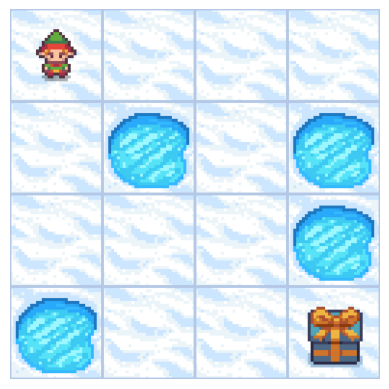

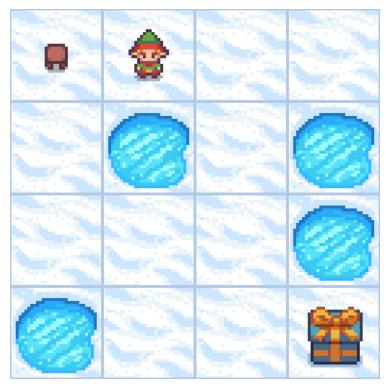

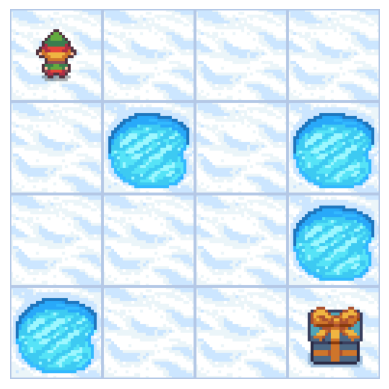

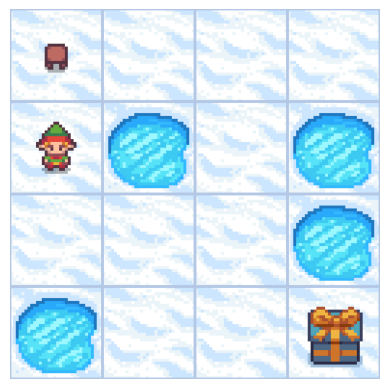

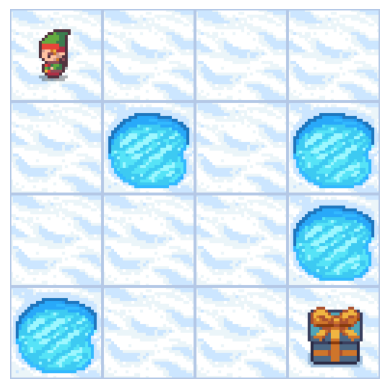

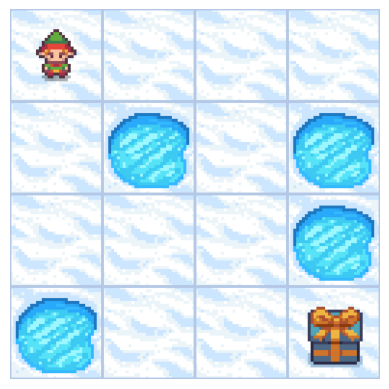

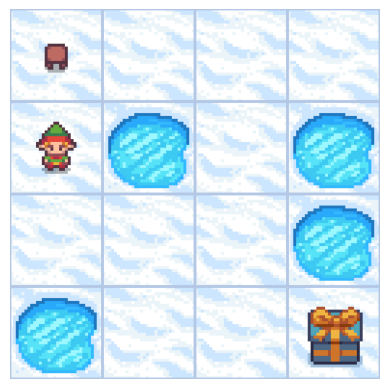

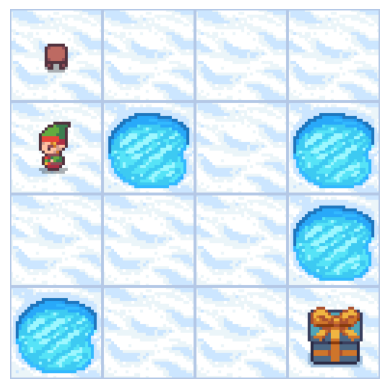

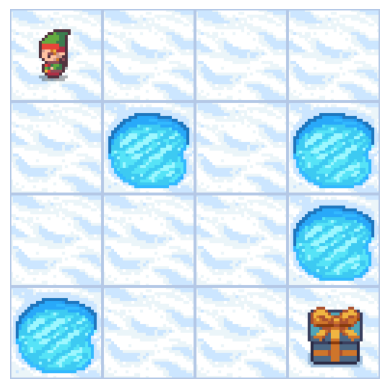

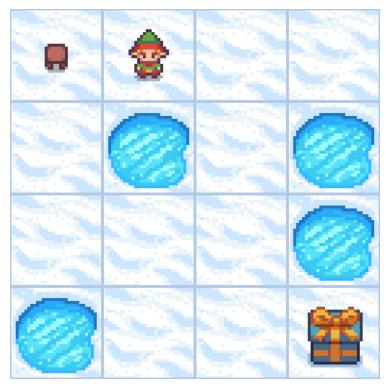

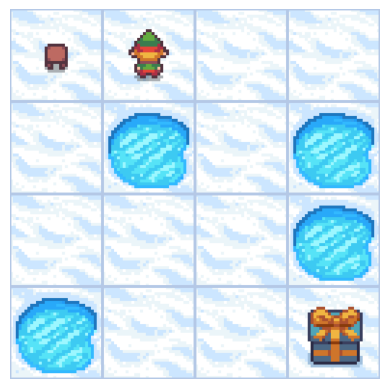

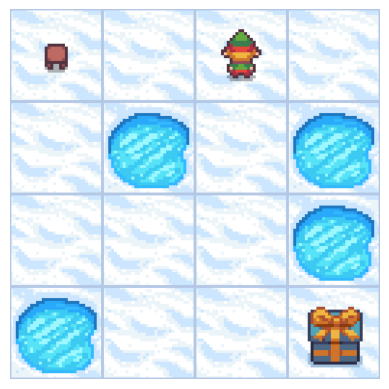

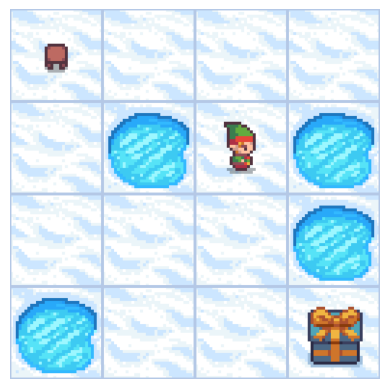

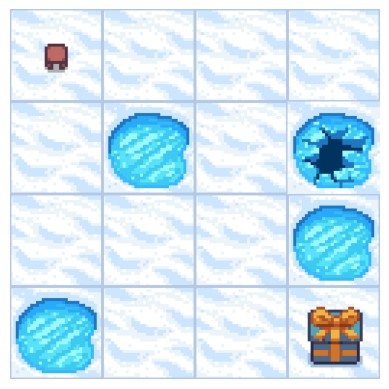

In [16]:
from matplotlib import pyplot as plt

frames = generate_episode(env, policy)

for i in range(len(frames)):
    # Use matplotlib to display the RGB array
    plt.imshow(frames[i])
    plt.axis('off')  # Hide the axis
    plt.show()

# create gif of the episode
import imageio
imageio.mimsave('frozenlake2.gif', frames, loop=True, duration=0.5*len(frames))